## 2D Attractors for Perceptual Decision Making
 
This notebook showcases the ability of our proposed **KoopSTD** to reliably differentiate between distinct dynamical systems, even when their condition-averaged trajectories appear identical.
 
The experimental setup and data generation procedures follow those described in Ostrow et al., 2024.

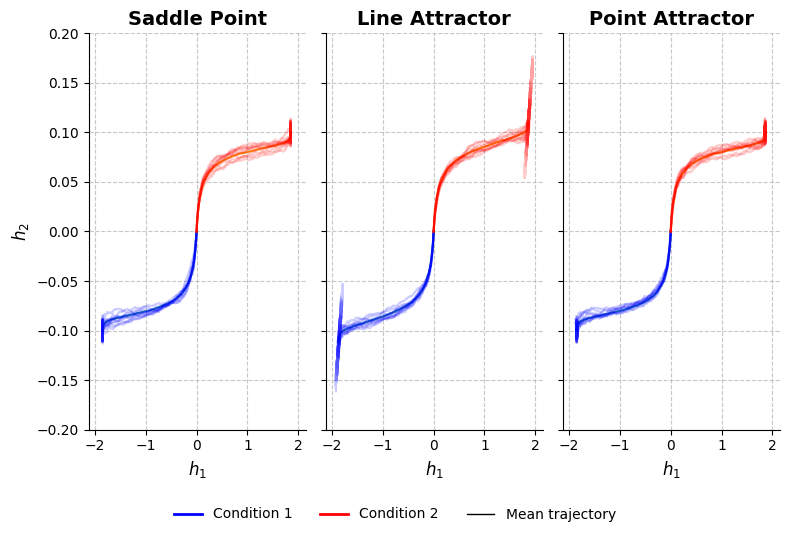

In [9]:
from koopstd.dynametric import KoopOpMetric
from koopstd.eval import MetricEvaluator
from koopstd.datasets import PDMAttractors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, MDS
import pandas as pd

pdm = PDMAttractors(n_samples=10, n_trials=100, sigma=0.05, simul_step=100, dt=0.01)
data = pdm.get_data()
pdm.visualization()

In [2]:
len(data), data[0].shape

(30, (200, 10000, 2))

### KoopSTD (Ours)

In [3]:
koopstd_params = {'hop_size': 128, 'win_len': 1024, 'rank': 5, 'lamb': 0} 
wasserstein_params = {'p': 1, 'method': 'emd'}
koopstd = KoopOpMetric(X=data, kmd_method='koopstd', kmd_params=koopstd_params, dist='wasserstein', dist_params=wasserstein_params, device='cuda')
koopstd_dist_matrix = koopstd.fit_score()

# Evaluate the performance of KoopSTD by Silhouette Coefficient
me = MetricEvaluator(distance_matrix=koopstd_dist_matrix, cluster_sizes=[10, 10, 10])
silhouette = me.evaluate()
print(silhouette)

0.9951934357975251


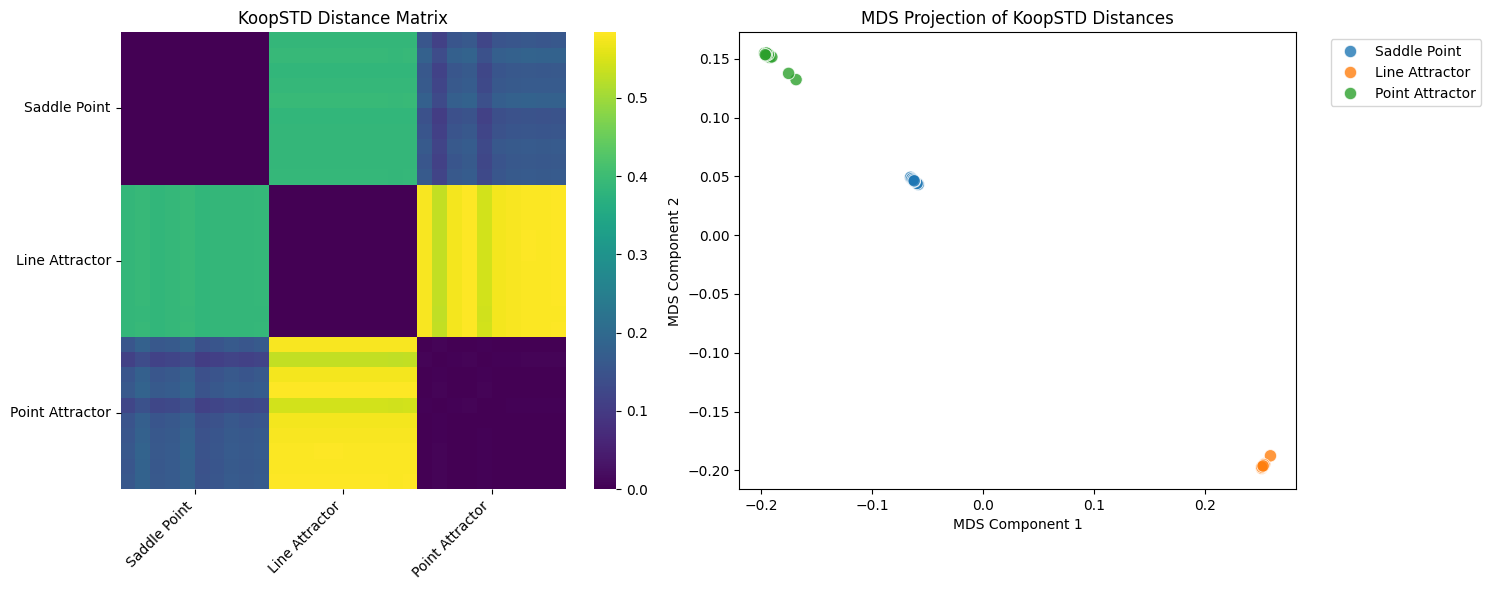

In [4]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot heatmap
sns.heatmap(koopstd_dist_matrix, cmap='viridis', ax=axes[0])
attractor_names = ['Saddle Point', 'Line Attractor', 'Point Attractor']
axes[0].set_title('KoopSTD Distance Matrix')

# Set custom tick labels
tick_positions = [5, 15, 25] 
axes[0].set_xticks(tick_positions)
axes[0].set_yticks(tick_positions)
axes[0].set_xticklabels(attractor_names, rotation=45, ha='right')
axes[0].set_yticklabels(attractor_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(koopstd_dist_matrix)

# Create DataFrame for scatter plot
df = pd.DataFrame()
df["x"] = embedding[:, 0]
df["y"] = embedding[:, 1]
system_labels = []
for attractor_type in attractor_names:
    system_labels.extend([attractor_type] * 10) 
df["System"] = system_labels

# Plot scatter with improved styling
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[1], s=80, alpha=0.8)
axes[1].set_title('MDS Projection of KoopSTD Distances')
axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Procrustes Analysis (Static Metric)

Computing Procrustes distances:   0%|          | 0/30 [00:00<?, ?it/s]

Computing Procrustes distances: 100%|██████████| 30/30 [02:57<00:00,  5.90s/it]


-0.11715326479411453


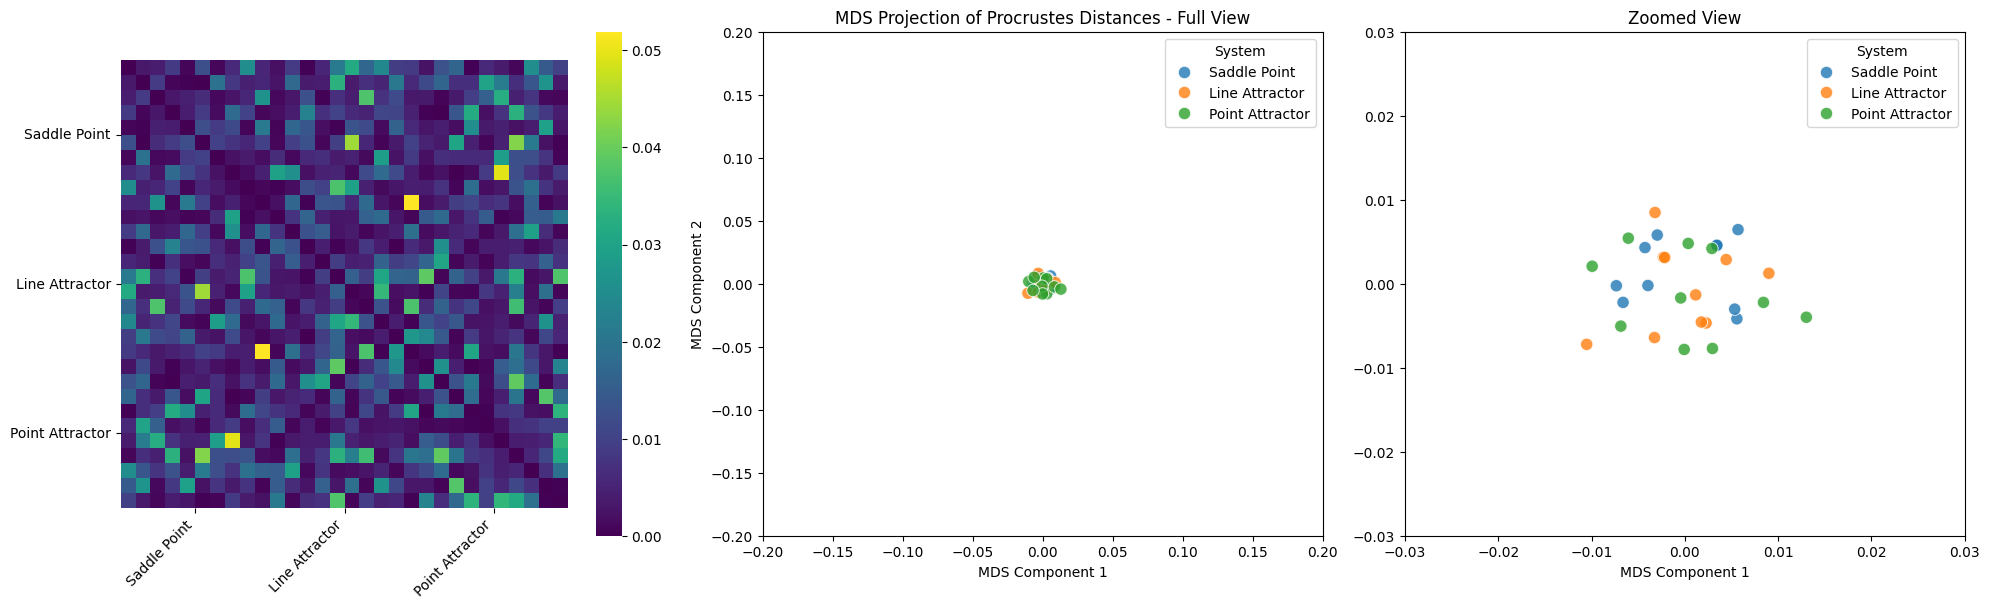

In [24]:
from koopstd.geometric import ProcrustesDistance
import numpy as np
from tqdm import tqdm

procrustes = ProcrustesDistance(iters=50, score_method="euclidean", group="O(n)", device="cuda")
sim = np.zeros((len(data), len(data)))
for i, d1 in enumerate(tqdm(data, desc="Computing Procrustes distances")):
    d1 = np.mean(d1, axis=1)
    d1 = d1.T @ d1
    for j, d2 in enumerate(data):
        d2 = np.mean(d2, axis=1)
        d2 = d2.T @ d2
        if j >= i:
            continue
        sim[i, j] = procrustes.compute(d1, d2)
        sim[j, i] = sim[i, j]

me = MetricEvaluator(distance_matrix=sim, cluster_sizes=[10, 10, 10])
silhouette = me.evaluate()
print(silhouette)


# Create a figure with three subplots - heatmap, main view, and zoomed view
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

attractor_names = ['Saddle Point', 'Line Attractor', 'Point Attractor']

# Plot heatmap of similarity matrix as the first plot
sns.heatmap(sim, ax=ax1, cmap='viridis', cbar=True, square=True)

# Set custom tick labels
tick_positions = [5, 15, 25] 
ax1.set_xticks(tick_positions)
ax1.set_yticks(tick_positions)
ax1.set_xticklabels(attractor_names, rotation=45, ha='right')
ax1.set_yticklabels(attractor_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(sim)

# Create DataFrame for scatter plot
df = pd.DataFrame()
df["x"] = embedding[:, 0]
df["y"] = embedding[:, 1]
system_labels = []
for attractor_type in attractor_names:
    system_labels.extend([attractor_type] * 10) 
df["System"] = system_labels

# Plot main view with original axis range
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=ax2, s=80, alpha=0.8)
ax2.set_title('MDS Projection of Procrustes Distances - Full View')
ax2.set_xlabel('MDS Component 1')
ax2.set_ylabel('MDS Component 2')
ax2.set_xlim(-0.2, 0.2)
ax2.set_ylim(-0.2, 0.2)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot zoomed view with tighter axis range
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=ax3, s=80, alpha=0.8)
ax3.set_title('Zoomed View')
ax3.set_xlabel('MDS Component 1')
ax3.set_ylabel('')
# Calculate tighter bounds based on data range
x_range = df["x"].max() - df["x"].min()
y_range = df["y"].max() - df["y"].min()
x_center = (df["x"].max() + df["x"].min()) / 2
y_center = (df["y"].max() + df["y"].min()) / 2
zoom_factor = 0.6  # Adjust this to control zoom level
ax3.set_xlim(-0.03, 0.03)
ax3.set_ylim(-0.03, 0.03)
# ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add legend to the right of the entire figure
handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.tight_layout()
plt.show()